<a href="https://colab.research.google.com/github/SangminAhn21/DL_Study/blob/main/Kaggle/Facial_Keypoint_Detection/Facial_Keypoint_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [4]:
pip install kaggle

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [6]:
!kaggle competitions download -c facial-keypoints-detection

  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 29.6MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 51.8MB/s]
 95% 57.0M/60.1M [00:02<00:00, 17.1MB/s]
100% 60.1M/60.1M [00:02<00:00, 27.2MB/s]
 56% 9.00M/16.0M [00:01<00:01, 6.33MB/s]
100% 16.0M/16.0M [00:01<00:00, 11.0MB/s]


In [7]:
IdLookupTable = pd.read_csv('IdLookupTable.csv')

In [8]:
IdLookupTable

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
...,...,...,...,...
27119,27120,1783,right_eye_center_y,NaN
27120,27121,1783,nose_tip_x,NaN
27121,27122,1783,nose_tip_y,NaN
27122,27123,1783,mouth_center_bottom_lip_x,NaN


In [9]:
SampleSubmission = pd.read_csv('SampleSubmission.csv')
SampleSubmission

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27119,27120,0
27120,27121,0
27121,27122,0
27122,27123,0


In [10]:
!unzip ../content/training.zip
!unzip ../content/test.zip

Archive:  ../content/training.zip
  inflating: training.csv            
Archive:  ../content/test.zip
  inflating: test.csv                


In [11]:
training_pd = pd.read_csv('training.csv')
test_pd = pd.read_csv('test.csv')

In [ ]:
training_pd.head()

In [13]:
training_pd.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [14]:
training_pd = training_pd.fillna(method='ffill')

In [15]:
training = training_pd.to_numpy()
test = test_pd.to_numpy()

In [16]:
print(training.shape)
print(test.shape)

(7049, 31)
(1783, 2)


In [17]:
train_image = training[:, -1]
train_key = training[:, :-1].astype('float64')
test_image = test[:, 1]
print(train_image.shape)
print(train_key.shape)
print(test_image.shape)

(7049,)
(7049, 30)
(1783,)


In [18]:
train_image = np.array([np.array([int(pixel) for pixel in image.split()]).reshape(96, 96) for image in train_image])
test_image = np.array([np.array([int(pixel) for pixel in image.split()]).reshape(96, 96) for image in test_image])

In [19]:
print(train_image.shape)
print(test_image.shape)

(7049, 96, 96)
(1783, 96, 96)


In [20]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

# from 'Facial Keypoint Detection - CNN + Augmentation' by Luong Quang Dung

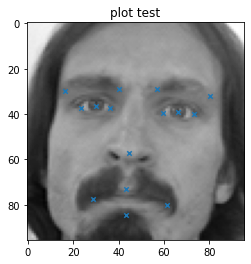

In [21]:
fig, axis = plt.subplots()
plot_sample(train_image[0], train_key[0], axis, 'plot test')

In [22]:
EPOCHS = 10
BATCH_SIZE = 32

In [23]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device: ', DEVICE)

Using PyTorch version: 1.9.0+cu111  Device:  cuda


In [24]:
class FaceDataset(Dataset):

    def __init__(self, x, y):
        self.len = x.shape[0]
        self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')
        self.y_data = torch.from_numpy(y).type('torch.FloatTensor')

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = FaceDataset(train_image, train_key)
print(len(dataset))

7049


In [25]:
lengths = [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)]
print(lengths)
train_data, val_data = torch.utils.data.random_split(dataset, lengths)
print(len(train_data))

[5639, 1410]
5639


In [26]:
train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

In [27]:
for (x_train, y_train) in train_loader:
  print("x_train:", x_train.size(), 'type:', x_train.type())
  print("y_train:", y_train.size(), 'type:', y_train.type())
  break

x_train: torch.Size([32, 96, 96]) type: torch.FloatTensor
y_train: torch.Size([32, 30]) type: torch.FloatTensor


In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(96 * 96, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 30)
    
    def forward(self, x):
        x = x.view(-1, 96 * 96)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # x = F.log_softmax(x, dim = 1)
        return x


In [29]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        eps = 1e-6
        loss = torch.sqrt(criterion(x, y) + eps)
        return loss

In [30]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
criterion = RMSELoss()

print(model)

Net(
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=30, bias=True)
)


In [31]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, key) in enumerate(train_loader):
        image = image.to(DEVICE)
        key = key.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, key)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                Epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))


In [32]:
def evaluate(model, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for image, key in val_loader:
            image = image.to(DEVICE)
            key = key.to(DEVICE)
            output = model(image)
            val_loss += criterion(output, key).item()

    val_loss /= len(val_loader.dataset)
    val_loss *= BATCH_SIZE
    return val_loss

In [33]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 20)
    val_loss = evaluate(model, val_loader)
    print('\n[EPOCH: {}], \tVal Loss: {:.4f}\n'.
          format(Epoch, val_loss))


Train Epoch: 1 [0/5639(0%)]	Train Loss: 51.629967
Train Epoch: 1 [640/5639(11%)]	Train Loss: 15.398744
Train Epoch: 1 [1280/5639(23%)]	Train Loss: 10.376804
Train Epoch: 1 [1920/5639(34%)]	Train Loss: 15.195989
Train Epoch: 1 [2560/5639(45%)]	Train Loss: 10.295881
Train Epoch: 1 [3200/5639(56%)]	Train Loss: 10.395805
Train Epoch: 1 [3840/5639(68%)]	Train Loss: 11.182585
Train Epoch: 1 [4480/5639(79%)]	Train Loss: 12.002717
Train Epoch: 1 [5120/5639(90%)]	Train Loss: 10.937307

[EPOCH: 1], 	Val Loss: 11.5936

Train Epoch: 2 [0/5639(0%)]	Train Loss: 11.421999
Train Epoch: 2 [640/5639(11%)]	Train Loss: 11.283047
Train Epoch: 2 [1280/5639(23%)]	Train Loss: 10.706867
Train Epoch: 2 [1920/5639(34%)]	Train Loss: 11.187675
Train Epoch: 2 [2560/5639(45%)]	Train Loss: 9.058608
Train Epoch: 2 [3200/5639(56%)]	Train Loss: 9.742188
Train Epoch: 2 [3840/5639(68%)]	Train Loss: 11.571812
Train Epoch: 2 [4480/5639(79%)]	Train Loss: 11.507338
Train Epoch: 2 [5120/5639(90%)]	Train Loss: 12.846910

[EPOCH

In [34]:
def predict(val_data, idx, plot=False):
    image_pred = val_data[idx][0].to(DEVICE)
    with torch.no_grad():
        prediction = model(image_pred)
    
    image_pred = image_pred.cpu().numpy()*255.
    prediction = prediction.cpu().numpy().reshape(30)
    answer = val_data[idx][1]

    if plot == True:
        fig, axis = plt.subplots()
        prediction_plot(image_pred, prediction, answer, axis, 'prediction plot for {}th image in val_data'.
                        format(idx))


In [39]:
def prediction_plot(image, keypoint, answer, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    axis.scatter(answer[0::2], answer[1::2], marker='x', color='r', s=20)
    plt.title(title)


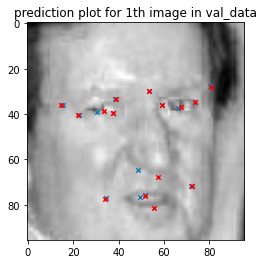

In [41]:
predict(val_data, 1, True)

In [60]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels = 1,
            out_channels = 3,
            kernel_size = 3,
            padding = 1)
        self.conv2 = nn.Conv2d(
            in_channels = 3,
            out_channels = 8,
            kernel_size = 3,
            padding = 1)
        self.pool = nn.MaxPool2d(
            kernel_size = 2,
            stride = 2)
        self.fc1 = nn.Linear(24 * 24 * 8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 30)
    
    def forward(self, x):
        x = x.view(-1, 1, 96, 96)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 24 * 24 * 8)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [63]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
criterion = RMSELoss()

print(model)

CNN(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=30, bias=True)
)


In [64]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 20)
    val_loss = evaluate(model, val_loader)
    print('\n[EPOCH: {}], \tVal Loss: {:.4f}\n'.
          format(Epoch, val_loss))


Train Epoch: 1 [0/5639(0%)]	Train Loss: 51.833168
Train Epoch: 1 [640/5639(11%)]	Train Loss: 9.077383
Train Epoch: 1 [1280/5639(23%)]	Train Loss: 4.021599
Train Epoch: 1 [1920/5639(34%)]	Train Loss: 3.275402
Train Epoch: 1 [2560/5639(45%)]	Train Loss: 4.383490
Train Epoch: 1 [3200/5639(56%)]	Train Loss: 4.178494
Train Epoch: 1 [3840/5639(68%)]	Train Loss: 3.420174
Train Epoch: 1 [4480/5639(79%)]	Train Loss: 2.925545
Train Epoch: 1 [5120/5639(90%)]	Train Loss: 2.687277

[EPOCH: 1], 	Val Loss: 3.6150

Train Epoch: 2 [0/5639(0%)]	Train Loss: 3.521922
Train Epoch: 2 [640/5639(11%)]	Train Loss: 3.612328
Train Epoch: 2 [1280/5639(23%)]	Train Loss: 2.682177
Train Epoch: 2 [1920/5639(34%)]	Train Loss: 2.988169
Train Epoch: 2 [2560/5639(45%)]	Train Loss: 3.786100
Train Epoch: 2 [3200/5639(56%)]	Train Loss: 2.661709
Train Epoch: 2 [3840/5639(68%)]	Train Loss: 2.684688
Train Epoch: 2 [4480/5639(79%)]	Train Loss: 2.810106
Train Epoch: 2 [5120/5639(90%)]	Train Loss: 3.065482

[EPOCH: 2], 	Val Loss:

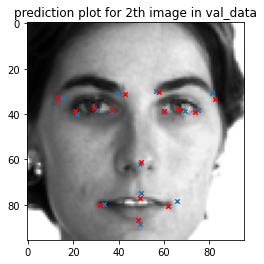

In [66]:
predict(val_data, 2, True)